In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [14]:
pip install git+https://github.com/SalesforceAIResearch/uni2ts.git

  Cloning https://github.com/SalesforceAIResearch/uni2ts.git to /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-yu_6wika
  Running command git clone --filter=blob:none --quiet https://github.com/SalesforceAIResearch/uni2ts.git /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-yu_6wika
  Resolved https://github.com/SalesforceAIResearch/uni2ts.git to commit cadebd82106e32409b7854b033dbd7a68de87fc0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


# Testing the model: context 96 prediction 96

#### HF: https://huggingface.co/Salesforce/moirai-1.0-R-large
#### Github: https://github.com/SalesforceAIResearch/uni2ts


Full Period Metrics:
MAE: 332.6930
MSE: 134978.3072
RMSE: 367.3939
MAPE: 5.8627
SMAPE: 5.6568
MASE: 10.4687


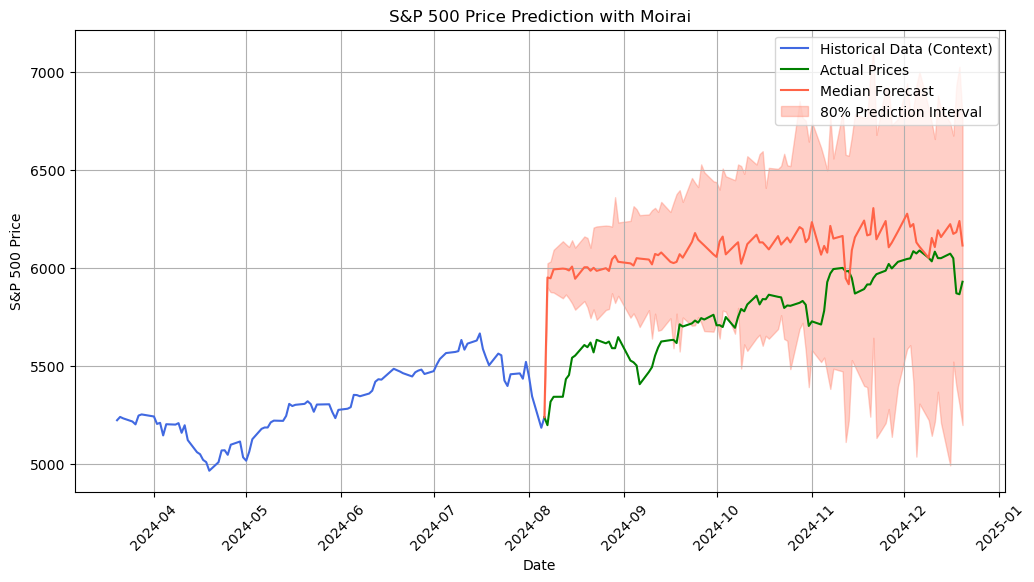


COVID Period Metrics:
MAE: 78.0720
MSE: 10894.8053
RMSE: 104.3782
MAPE: 1.7410
SMAPE: 1.7205
MASE: 3.5518


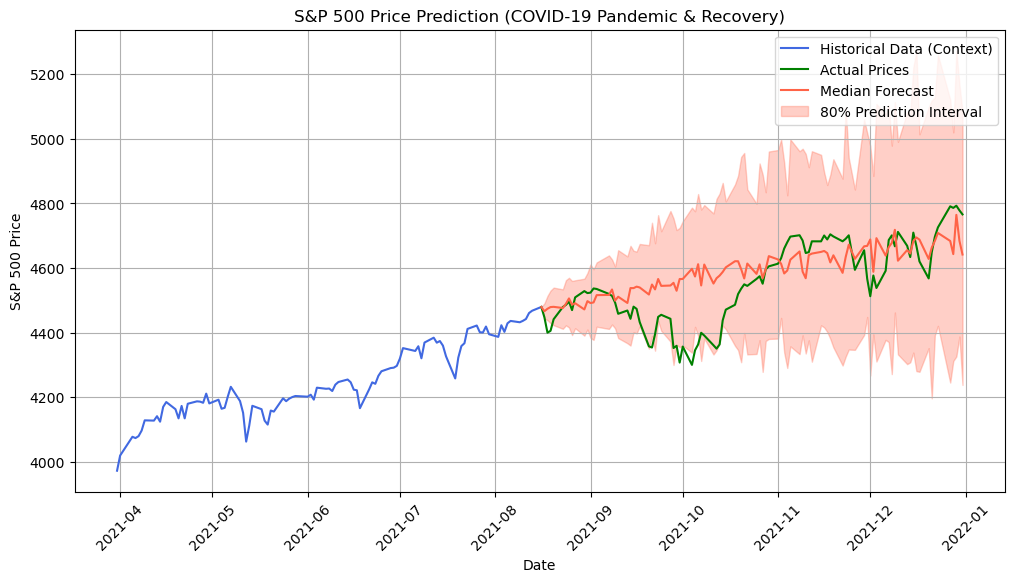

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

from data.snp500 import snp500_daily
from utils.metrics import metric

CONTEXT_WINDOW = 96
PREDICTION_WINDOW = 96

# Initialize Moirai model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained("Salesforce/moirai-1.0-R-small"),
    prediction_length=PREDICTION_WINDOW,
    context_length=CONTEXT_WINDOW,
    patch_size="auto",
    num_samples=100,  # For generating prediction intervals
    target_dim=1,
    feat_dynamic_real_dim=0,  # No additional features
    past_feat_dynamic_real_dim=0,
)
predictor = model.create_predictor(batch_size=32)

# Prepare the data - using raw Close prices
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]


def generate_forecast(context_data):
    """Generate and process forecast using Moirai"""
    # Ensure data is 1D
    context = np.asarray(context_data).flatten()

    # Create a pandas Series with datetime index
    dates = pd.date_range(end=pd.Timestamp.now(), periods=len(context), freq="D")
    context_series = pd.Series(context, index=dates)

    # Prepare data in GluonTS format
    dataset = PandasDataset({"target": context_series})

    # Generate forecast
    forecasts = list(predictor.predict(dataset))[0]
    forecast_samples = forecasts.samples

    # Extract quantiles
    low, median, high = np.quantile(forecast_samples, [0.1, 0.5, 0.9], axis=0)
    return low, median, high


def calculate_metrics(actual, predicted, insample=None):
    """Calculate all metrics using the metrics.py implementations"""
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()

    # Calculate basic metrics
    mae, mse, rmse, mape, mspe = metric(predicted, actual)

    # Calculate SMAPE
    smape = 200 * np.mean(
        np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual))
    )

    # Calculate MASE
    if insample is not None:
        # Calculate naive forecast error (using t-1 as prediction for t)
        naive_forecast = insample[:-1]  # Previous values
        naive_target = insample[1:]  # Current values
        naive_mae = np.mean(np.abs(naive_target - naive_forecast))

        # Calculate MASE
        mase = mae / naive_mae if naive_mae != 0 else np.nan
    else:
        mase = np.nan

    metrics = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape * 100,  # Convert to percentage
        "SMAPE": smape,
        "MASE": mase if not np.isnan(mase) else None,
    }

    return metrics


def plot_forecast(
    data,
    context_window,
    prediction_window,
    median_forecast,
    low_forecast,
    high_forecast,
    title,
):
    """Create visualization with zoomed context"""
    plt.figure(figsize=(12, 6))

    # Get the last point of historical context
    last_context_point = data["Close"].iloc[-prediction_window - 1]

    # Add last context point to forecasts for continuity
    median_forecast = np.insert(median_forecast, 0, last_context_point)
    low_forecast = np.insert(low_forecast, 0, last_context_point)
    high_forecast = np.insert(high_forecast, 0, last_context_point)

    # Create forecast dates
    forecast_dates = pd.concat(
        [
            data["Date"].iloc[-(prediction_window + 1) : -prediction_window],
            data["Date"].iloc[-prediction_window:],
        ]
    )

    # Get actual prices including last context point
    actual_prices = data["Close"].iloc[-prediction_window:].values
    actual_prices = np.insert(actual_prices, 0, last_context_point)

    # Plot historical context
    plt.plot(
        data["Date"].iloc[-(context_window + prediction_window) : -prediction_window],
        data["Close"].iloc[-(context_window + prediction_window) : -prediction_window],
        color="royalblue",
        label="Historical Data (Context)",
    )

    # Plot actual prices
    plt.plot(forecast_dates, actual_prices, color="green", label="Actual Prices")

    # Plot forecast
    plt.plot(forecast_dates, median_forecast, color="tomato", label="Median Forecast")
    plt.fill_between(
        forecast_dates,
        low_forecast,
        high_forecast,
        color="tomato",
        alpha=0.3,
        label="80% Prediction Interval",
    )

    plt.xlabel("Date")
    plt.ylabel("S&P 500 Price")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()


# Generate full period forecast
context = sp500_d["Close"].values[-CONTEXT_WINDOW:]
low, median, high = generate_forecast(context)

# Calculate and print metrics for full period
actual_prices = sp500_d["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_d["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_d,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with Moirai",
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_d[
    (sp500_d["Date"] >= covid_start_date) & (sp500_d["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)

low_covid, median_covid, high_covid = generate_forecast(covid_context)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Full Period Metrics:
MAE: 90.8481
MSE: 12471.9277
RMSE: 111.6778
MAPE: 1.5464
SMAPE: 1.5336
MASE: 2.4894


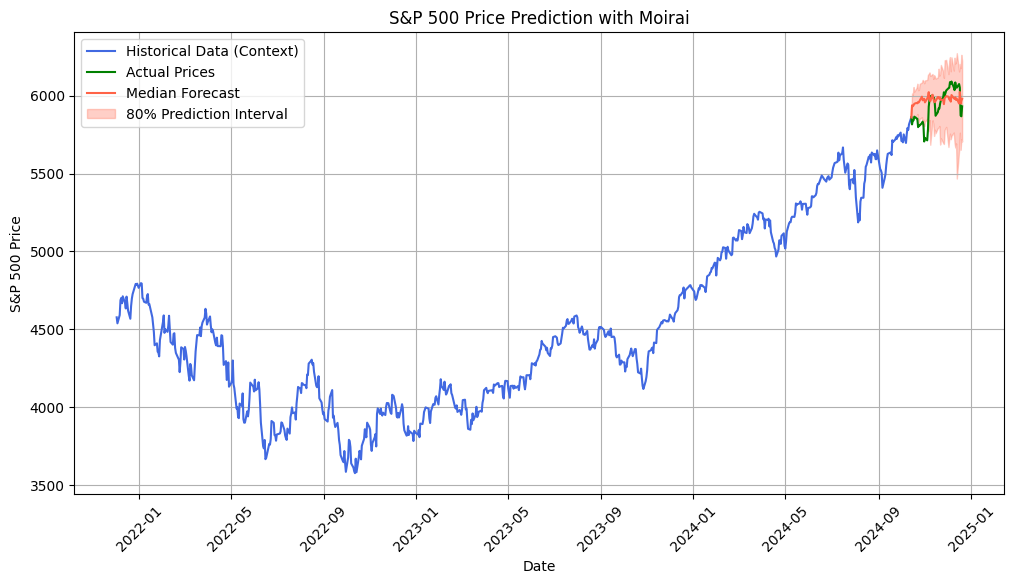


COVID Period Metrics:
MAE: 159.0915
MSE: 29538.2736
RMSE: 171.8670
MAPE: 3.3943
SMAPE: 3.4625
MASE: 4.6515


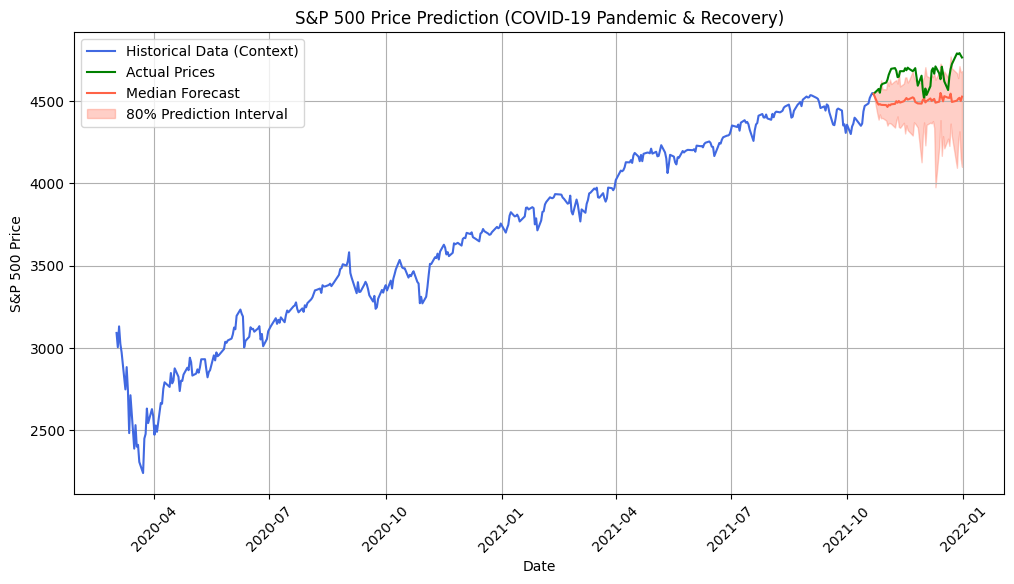

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

from data.snp500 import snp500_daily
from utils.metrics import metric

CONTEXT_WINDOW = 720
PREDICTION_WINDOW = 48

# Initialize Moirai model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained("Salesforce/moirai-1.0-R-small"),
    prediction_length=PREDICTION_WINDOW,
    context_length=CONTEXT_WINDOW,
    patch_size="auto",
    num_samples=100,  # For generating prediction intervals
    target_dim=1,
    feat_dynamic_real_dim=0,  # No additional features
    past_feat_dynamic_real_dim=0,
)
predictor = model.create_predictor(batch_size=32)

# Prepare the data - using raw Close prices
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]


def generate_forecast(context_data):
    """Generate and process forecast using Moirai"""
    # Ensure data is 1D
    context = np.asarray(context_data).flatten()

    # Create a pandas Series with datetime index
    dates = pd.date_range(end=pd.Timestamp.now(), periods=len(context), freq="D")
    context_series = pd.Series(context, index=dates)

    # Prepare data in GluonTS format
    dataset = PandasDataset({"target": context_series})

    # Generate forecast
    forecasts = list(predictor.predict(dataset))[0]
    forecast_samples = forecasts.samples

    # Extract quantiles
    low, median, high = np.quantile(forecast_samples, [0.1, 0.5, 0.9], axis=0)
    return low, median, high


def calculate_metrics(actual, predicted, insample=None):
    """Calculate all metrics using the metrics.py implementations"""
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()

    # Calculate basic metrics
    mae, mse, rmse, mape, mspe = metric(predicted, actual)

    # Calculate SMAPE
    smape = 200 * np.mean(
        np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual))
    )

    # Calculate MASE
    if insample is not None:
        # Calculate naive forecast error (using t-1 as prediction for t)
        naive_forecast = insample[:-1]  # Previous values
        naive_target = insample[1:]  # Current values
        naive_mae = np.mean(np.abs(naive_target - naive_forecast))

        # Calculate MASE
        mase = mae / naive_mae if naive_mae != 0 else np.nan
    else:
        mase = np.nan

    metrics = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape * 100,  # Convert to percentage
        "SMAPE": smape,
        "MASE": mase if not np.isnan(mase) else None,
    }

    return metrics


def plot_forecast(
    data,
    context_window,
    prediction_window,
    median_forecast,
    low_forecast,
    high_forecast,
    title,
):
    """Create visualization with zoomed context"""
    plt.figure(figsize=(12, 6))

    # Get the last point of historical context
    last_context_point = data["Close"].iloc[-prediction_window - 1]

    # Add last context point to forecasts for continuity
    median_forecast = np.insert(median_forecast, 0, last_context_point)
    low_forecast = np.insert(low_forecast, 0, last_context_point)
    high_forecast = np.insert(high_forecast, 0, last_context_point)

    # Create forecast dates
    forecast_dates = pd.concat(
        [
            data["Date"].iloc[-(prediction_window + 1) : -prediction_window],
            data["Date"].iloc[-prediction_window:],
        ]
    )

    # Get actual prices including last context point
    actual_prices = data["Close"].iloc[-prediction_window:].values
    actual_prices = np.insert(actual_prices, 0, last_context_point)

    # Plot historical context
    plt.plot(
        data["Date"].iloc[-(context_window + prediction_window) : -prediction_window],
        data["Close"].iloc[-(context_window + prediction_window) : -prediction_window],
        color="royalblue",
        label="Historical Data (Context)",
    )

    # Plot actual prices
    plt.plot(forecast_dates, actual_prices, color="green", label="Actual Prices")

    # Plot forecast
    plt.plot(forecast_dates, median_forecast, color="tomato", label="Median Forecast")
    plt.fill_between(
        forecast_dates,
        low_forecast,
        high_forecast,
        color="tomato",
        alpha=0.3,
        label="80% Prediction Interval",
    )

    plt.xlabel("Date")
    plt.ylabel("S&P 500 Price")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()


# Generate full period forecast
context = sp500_d["Close"].values[-CONTEXT_WINDOW:]
low, median, high = generate_forecast(context)

# Calculate and print metrics for full period
actual_prices = sp500_d["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_d["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_d,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with Moirai",
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_d[
    (sp500_d["Date"] >= covid_start_date) & (sp500_d["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)

low_covid, median_covid, high_covid = generate_forecast(covid_context)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)


# Experimenting with different context and prediction windows for different frequencies: daily, weekly, monthly


Running daily frequency experiments...


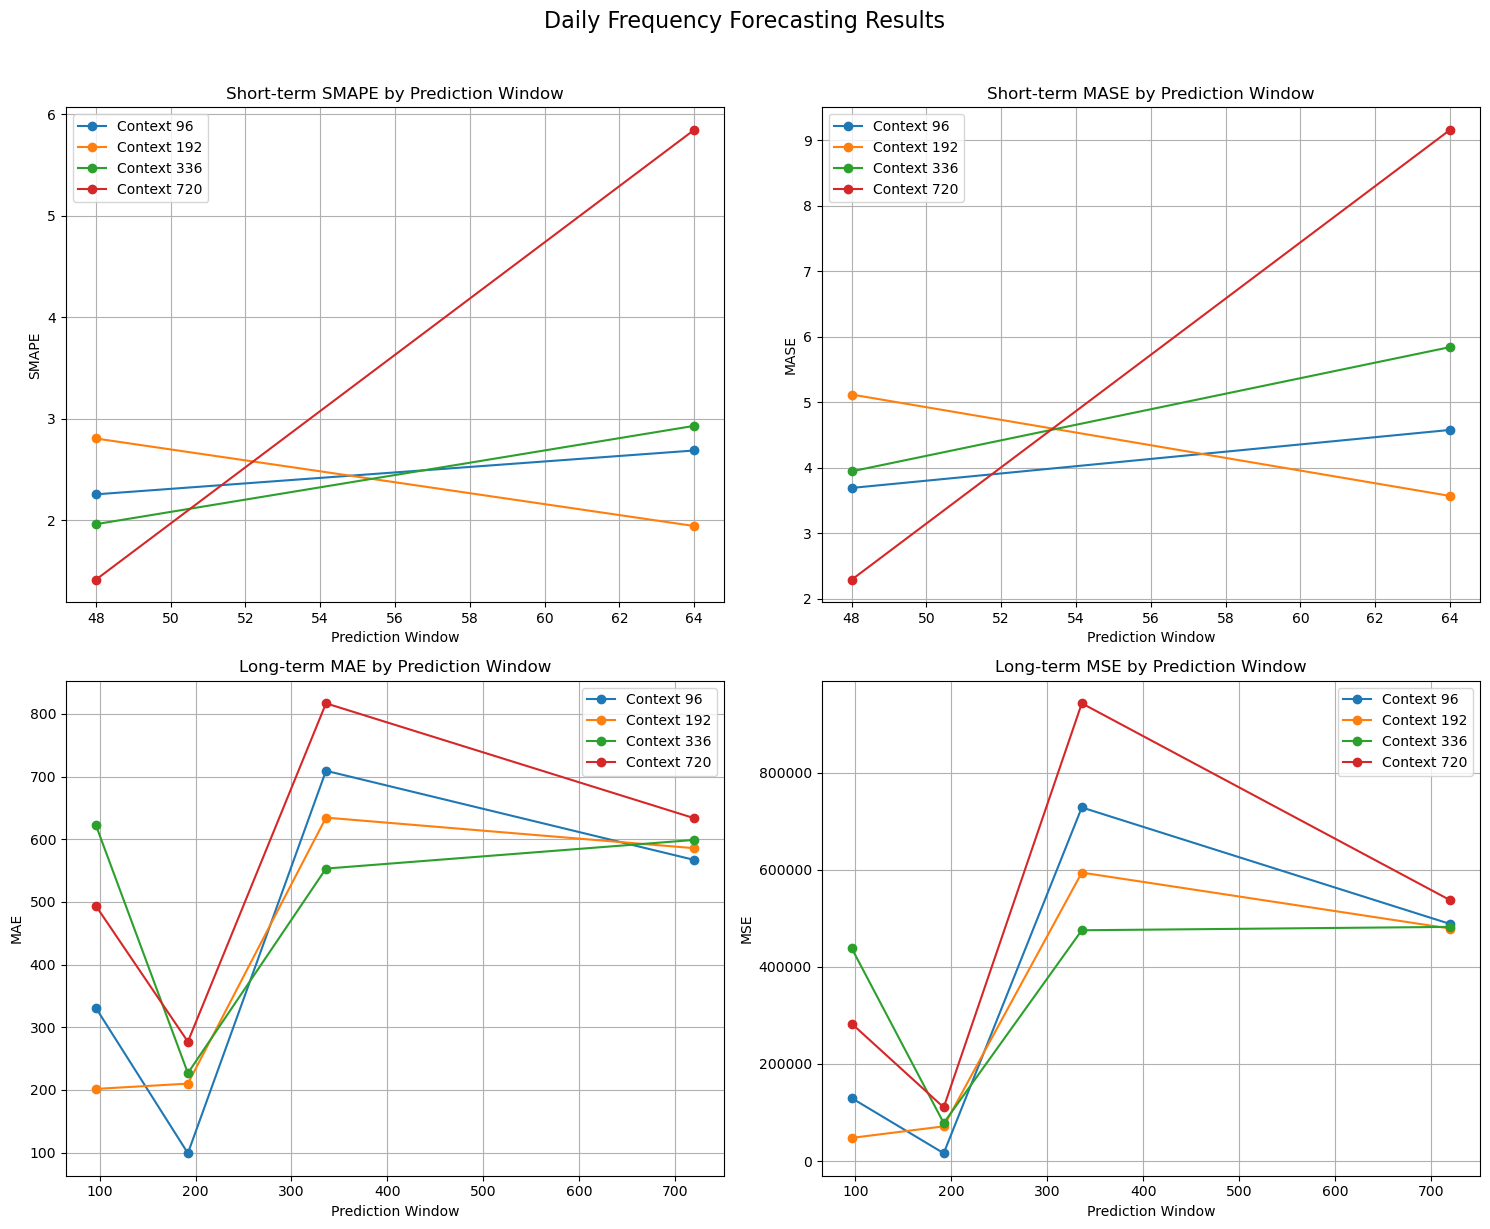


Daily Frequency Results:

Short-term Forecasting Results:
Metric                                 MAE    MAPE    MASE          MSE  \
Context Window Prediction Window                                          
96             48                 132.8321  2.2235  3.6948   24421.9552   
               64                 157.0740  2.6347  4.5807   36214.8516   
192            48                 164.6101  2.7521  5.1211   38790.0665   
               64                 113.9668  1.9159  3.5725   18321.3488   
336            48                 115.7569  1.9475  3.9480   16901.4553   
               64                 171.0664  2.8742  5.8451   39229.8421   
720            48                  83.6935  1.4095  2.2934   10976.2687   
               64                 335.4063  5.6485  9.1625  135518.0871   

Metric                                RMSE   SMAPE  
Context Window Prediction Window                    
96             48                 156.2753  2.2538  
               64              

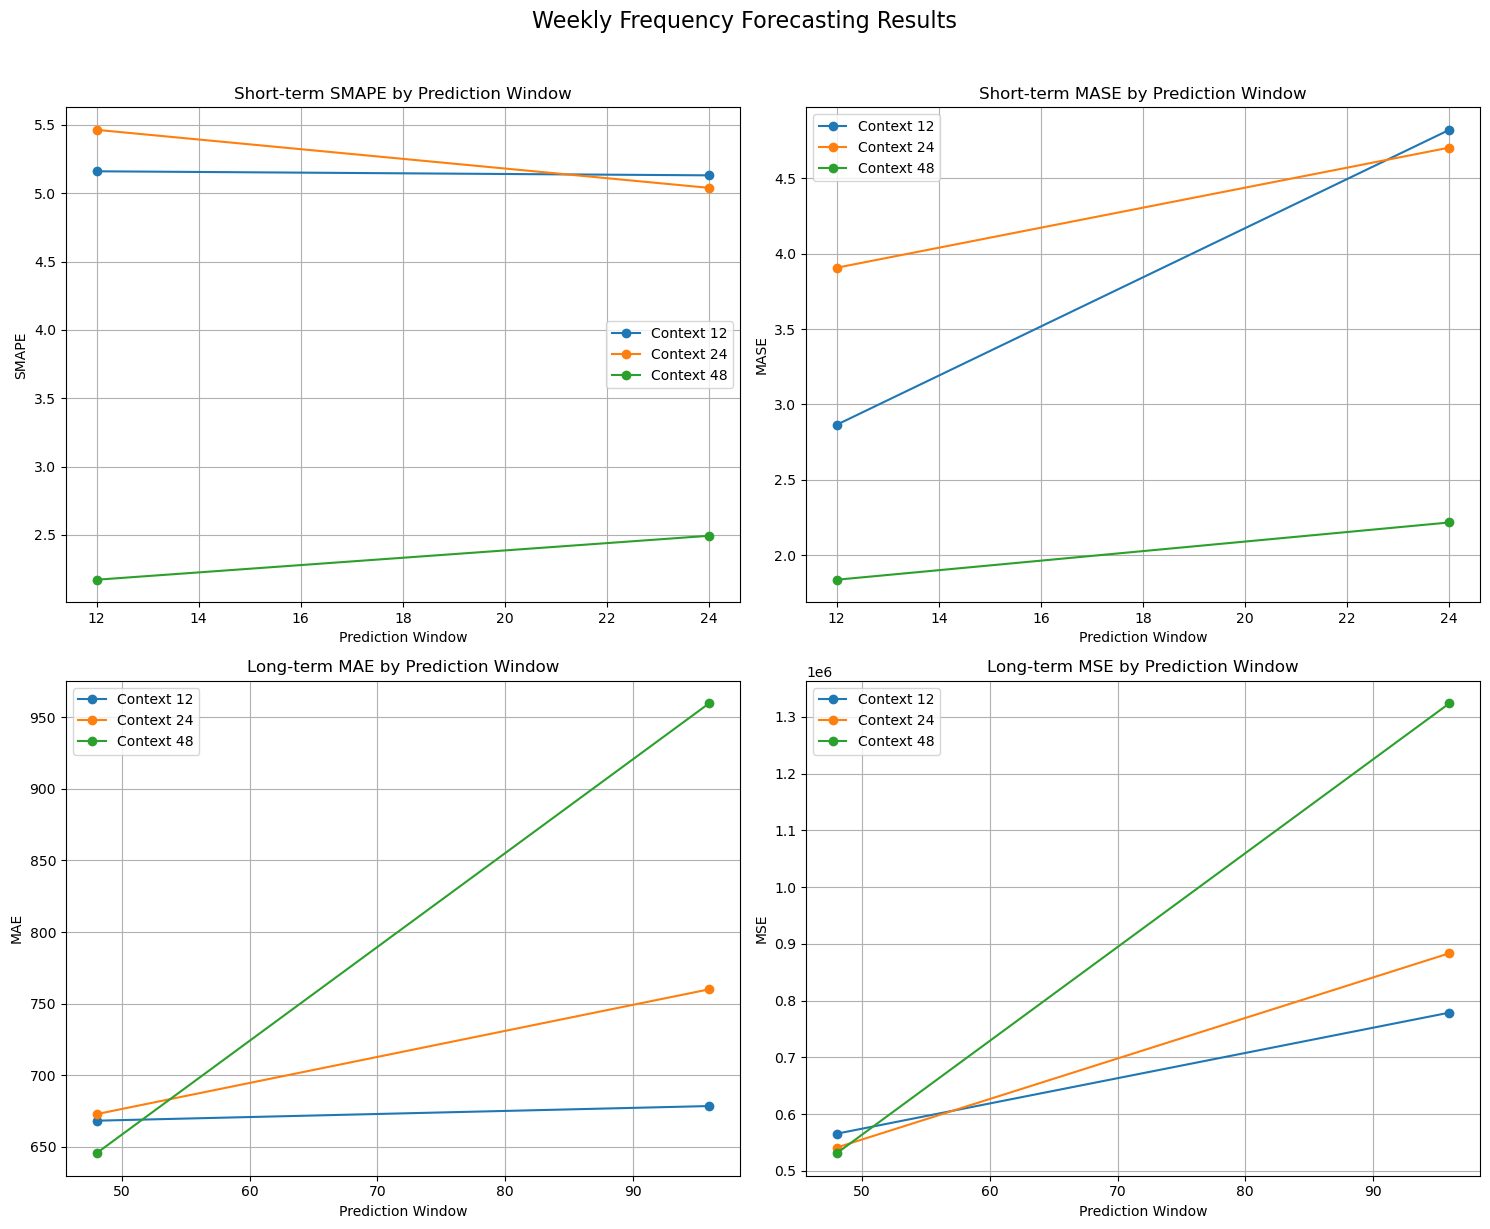


Weekly Frequency Results:

Short-term Forecasting Results:
Metric                                 MAE    MAPE    MASE          MSE  \
Context Window Prediction Window                                          
12             12                 298.3475  5.0071  2.8658  106869.4245   
               24                 290.4426  4.9617  4.8213  118880.9645   
24             12                 315.2700  5.2935  3.9069  118324.5950   
               24                 285.3171  4.8719  4.7034  118221.1580   
48             12                 127.7309  2.1339  1.8379   27149.6438   
               24                 143.0760  2.4601  2.2177   34314.0985   

Metric                                RMSE   SMAPE  
Context Window Prediction Window                    
12             12                 326.9089  5.1610  
               24                 344.7912  5.1313  
24             12                 343.9834  5.4644  
               24                 343.8330  5.0396  
48             12    

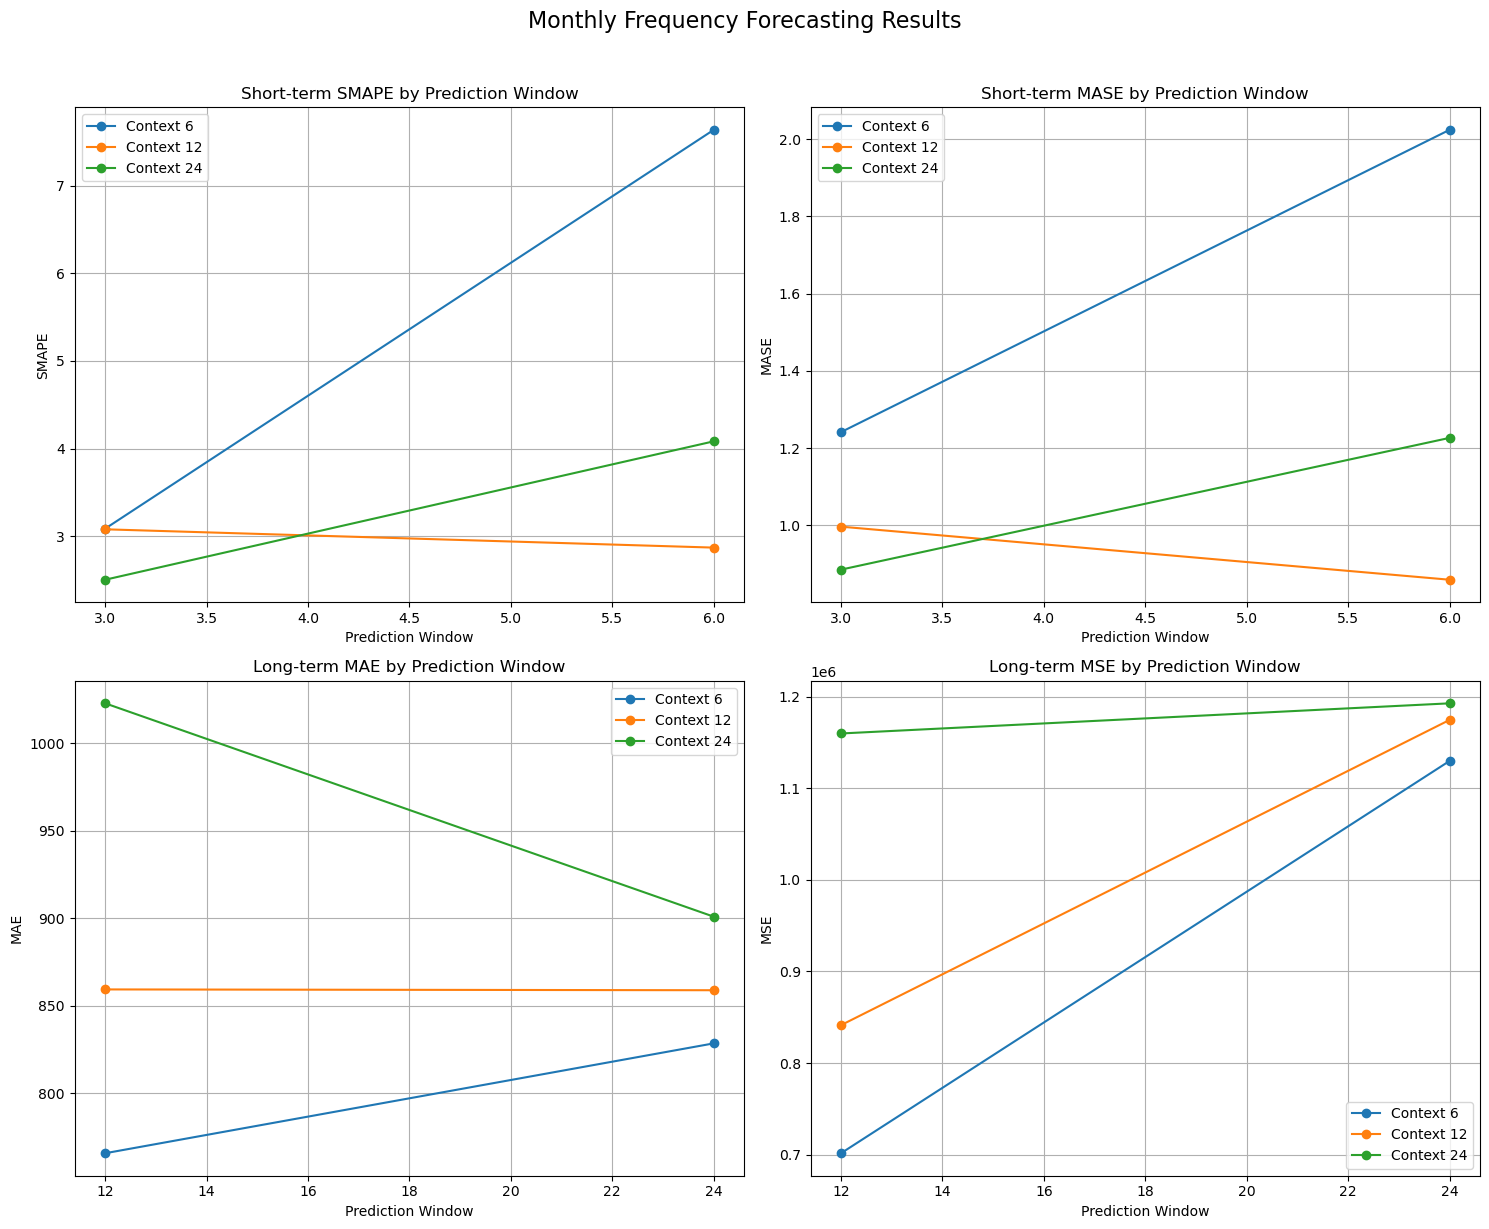


Monthly Frequency Results:

Short-term Forecasting Results:
Metric                                 MAE    MAPE    MASE          MSE  \
Context Window Prediction Window                                          
6              3                  180.4381  3.0809  1.2413   32944.7486   
               6                  425.9825  7.3217  2.0243  208970.4963   
12             3                  181.7073  3.1289  0.9964   41586.3073   
               6                  163.9090  2.8278  0.8589   34489.0190   
24             3                  146.7032  2.4930  0.8851   25533.2523   
               6                  231.4774  3.9842  1.2264   65191.6285   

Metric                                RMSE   SMAPE  
Context Window Prediction Window                    
6              3                  181.5069  3.0856  
               6                  457.1329  7.6396  
12             3                  203.9272  3.0780  
               6                  185.7122  2.8690  
24             3    

In [9]:
from data.snp500 import snp500_daily, snp500_monthly, snp500_weekly
from utils.evaluate import ContextPredictionWindowEvaluator


def moirai_forecast(model, context, prediction_window):
    """Forecast function for Moirai model"""
    # Ensure data is 1D
    context = np.asarray(context).flatten()

    # Create a pandas Series with datetime index
    dates = pd.date_range(end=pd.Timestamp.now(), periods=len(context), freq="D")
    context_series = pd.Series(context, index=dates)

    # Create new model instance with correct prediction length
    model_instance = MoiraiForecast(
        module=MoiraiModule.from_pretrained("Salesforce/moirai-1.0-R-small"),
        prediction_length=prediction_window,
        context_length=len(context),
        patch_size="auto",
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )
    predictor = model_instance.create_predictor(batch_size=32)

    # Prepare data in GluonTS format
    dataset = PandasDataset({"target": context_series})

    # Generate forecast
    forecasts = list(predictor.predict(dataset))[0]
    forecast_samples = forecasts.samples

    # Extract quantiles and ensure correct length
    low, median, high = np.quantile(forecast_samples, [0.1, 0.5, 0.9], axis=0)

    # Verify lengths match expected prediction window
    assert (
        len(median) == prediction_window
    ), f"Prediction length mismatch: got {len(median)}, expected {prediction_window}"

    return low, median, high


def plot_results_by_frequency(results_df, frequency):
    """Create plots for short-term and long-term metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(
        f"{frequency.capitalize()} Frequency Forecasting Results", fontsize=16, y=1.02
    )

    # Short-term metrics (SMAPE and MASE)
    short_term = results_df[results_df["Horizon"] == "short_term"]
    context_windows = sorted(short_term["Context Window"].unique())

    # Plot SMAPE
    ax = axes[0, 0]
    for context in context_windows:
        data = short_term[
            (short_term["Context Window"] == context)
            & (short_term["Metric"] == "SMAPE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("SMAPE")
    ax.set_title("Short-term SMAPE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Plot MASE
    ax = axes[0, 1]
    for context in context_windows:
        data = short_term[
            (short_term["Context Window"] == context) & (short_term["Metric"] == "MASE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MASE")
    ax.set_title("Short-term MASE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Long-term metrics (MAE and MSE)
    long_term = results_df[results_df["Horizon"] == "long_term"]

    # Plot MAE
    ax = axes[1, 0]
    for context in context_windows:
        data = long_term[
            (long_term["Context Window"] == context) & (long_term["Metric"] == "MAE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MAE")
    ax.set_title("Long-term MAE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Plot MSE
    ax = axes[1, 1]
    for context in context_windows:
        data = long_term[
            (long_term["Context Window"] == context) & (long_term["Metric"] == "MSE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MSE")
    ax.set_title("Long-term MSE by Prediction Window")
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()


# Initialize experiment runner with dummy model (will be recreated for each prediction)
dummy_model = None  # Model will be created dynamically in moirai_forecast

experiments = ContextPredictionWindowEvaluator(
    model=dummy_model, forecast_fn=moirai_forecast
)

# Dictionary to store results for each frequency
frequency_results = {}

# Run experiments for each frequency
frequencies = {
    "daily": snp500_daily,
    "weekly": snp500_weekly,
    "monthly": snp500_monthly,
}

for freq, data in frequencies.items():
    print(f"\nRunning {freq} frequency experiments...")

    # Run experiments
    results = experiments.run_frequency_experiments(data, freq)
    frequency_results[freq] = results

    # Format results
    df_results = experiments.format_results(results)

    # Create visualizations
    plot_results_by_frequency(df_results, freq)

    # Create separate DataFrames for short-term and long-term results
    short_term_df = (
        df_results[df_results["Horizon"] == "short_term"]
        .pivot_table(
            index=["Context Window", "Prediction Window"],
            columns="Metric",
            values="Value",
        )
        .round(4)
    )

    long_term_df = (
        df_results[df_results["Horizon"] == "long_term"]
        .pivot_table(
            index=["Context Window", "Prediction Window"],
            columns="Metric",
            values="Value",
        )
        .round(4)
    )

    print(f"\n{freq.capitalize()} Frequency Results:")
    print("\nShort-term Forecasting Results:")
    print(short_term_df)
    print("\nLong-term Forecasting Results:")
    print(long_term_df)


## Best long-term and short-term forecasting results for context and prediction window experiment at different frequencies

In [1]:
best_configs = {
    'daily': {
        'short': {
            'context': 720,
            'prediction': 48,
            'smape': 1.4125,
            'mase': 2.2934
        },
        'long': {
            'context': 96,
            'prediction': 192,
            'mse': 16319.22,
            'mae': 98.93
        }
    },
    'weekly': {
        'short': {
            'context': 48,
            'prediction': 12,
            'smape': 2.1719,
            'mase': 1.8379
        },
        'long': {
            'context': 12,
            'prediction': 48,
            'mse': 565481.1,
            'mae': 668.35
        }
    },
    'monthly': {
        'short': {
            'context': 24,
            'prediction': 3,
            'smape': 2.5022,
            'mase': 0.8851
        },
        'long': {
            'context': 6,
            'prediction': 12,
            'mse': 701552.2,
            'mae': 765.78
        }
    }
}

# Forecasting visuals of best performing runs for recent and COVID-19 periods

Generating plots for extended period...


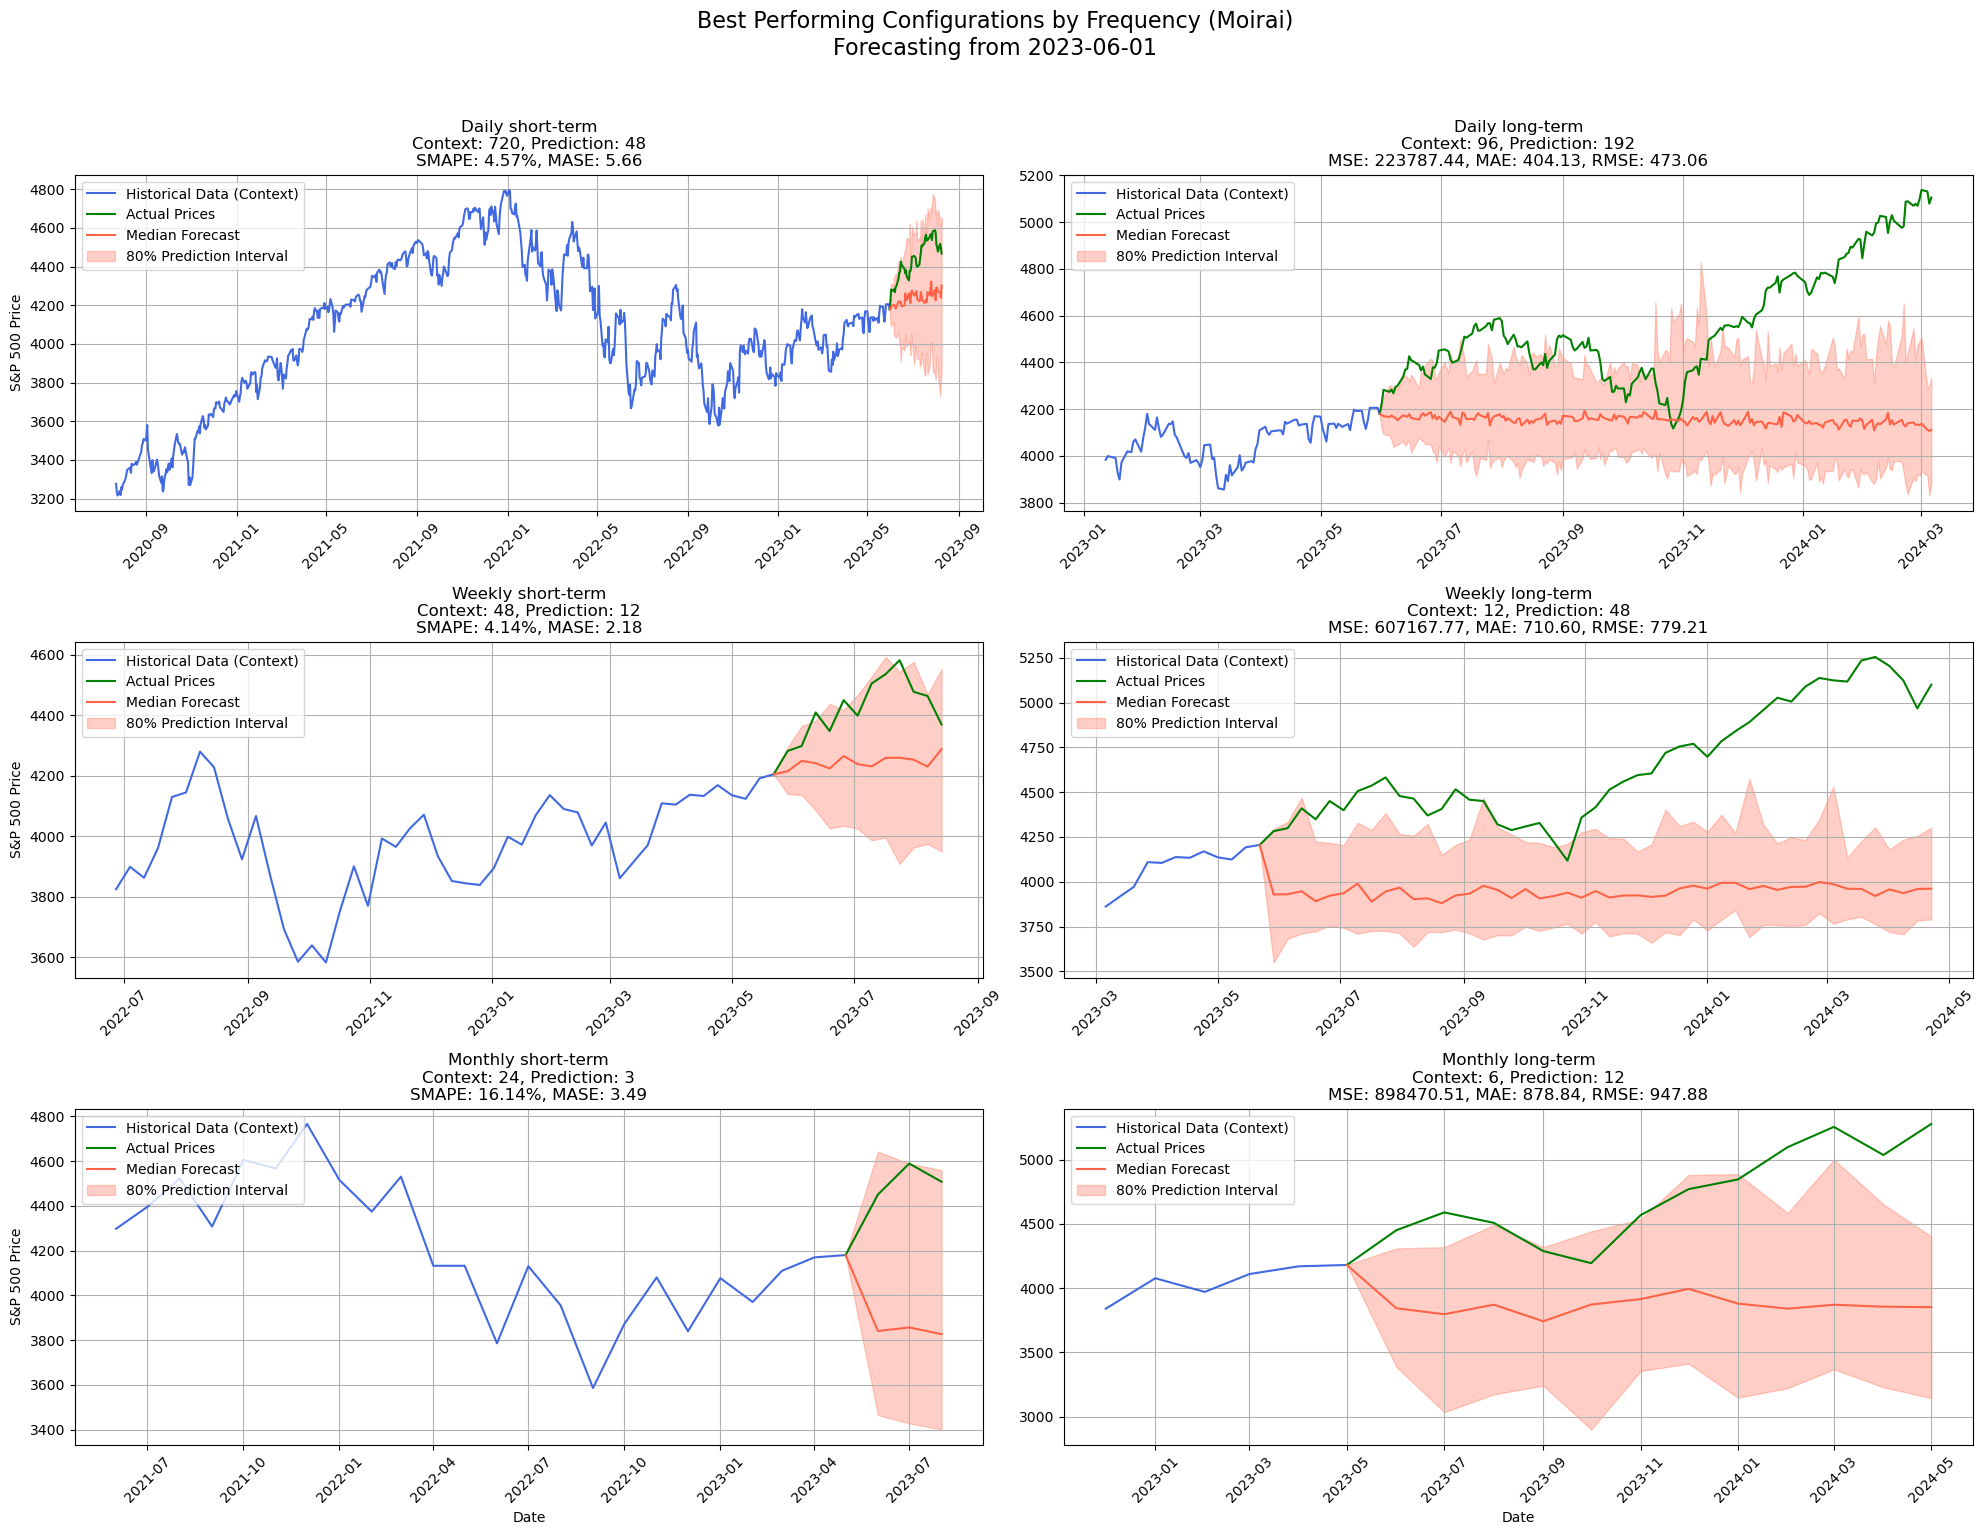


Generating plots for COVID period...


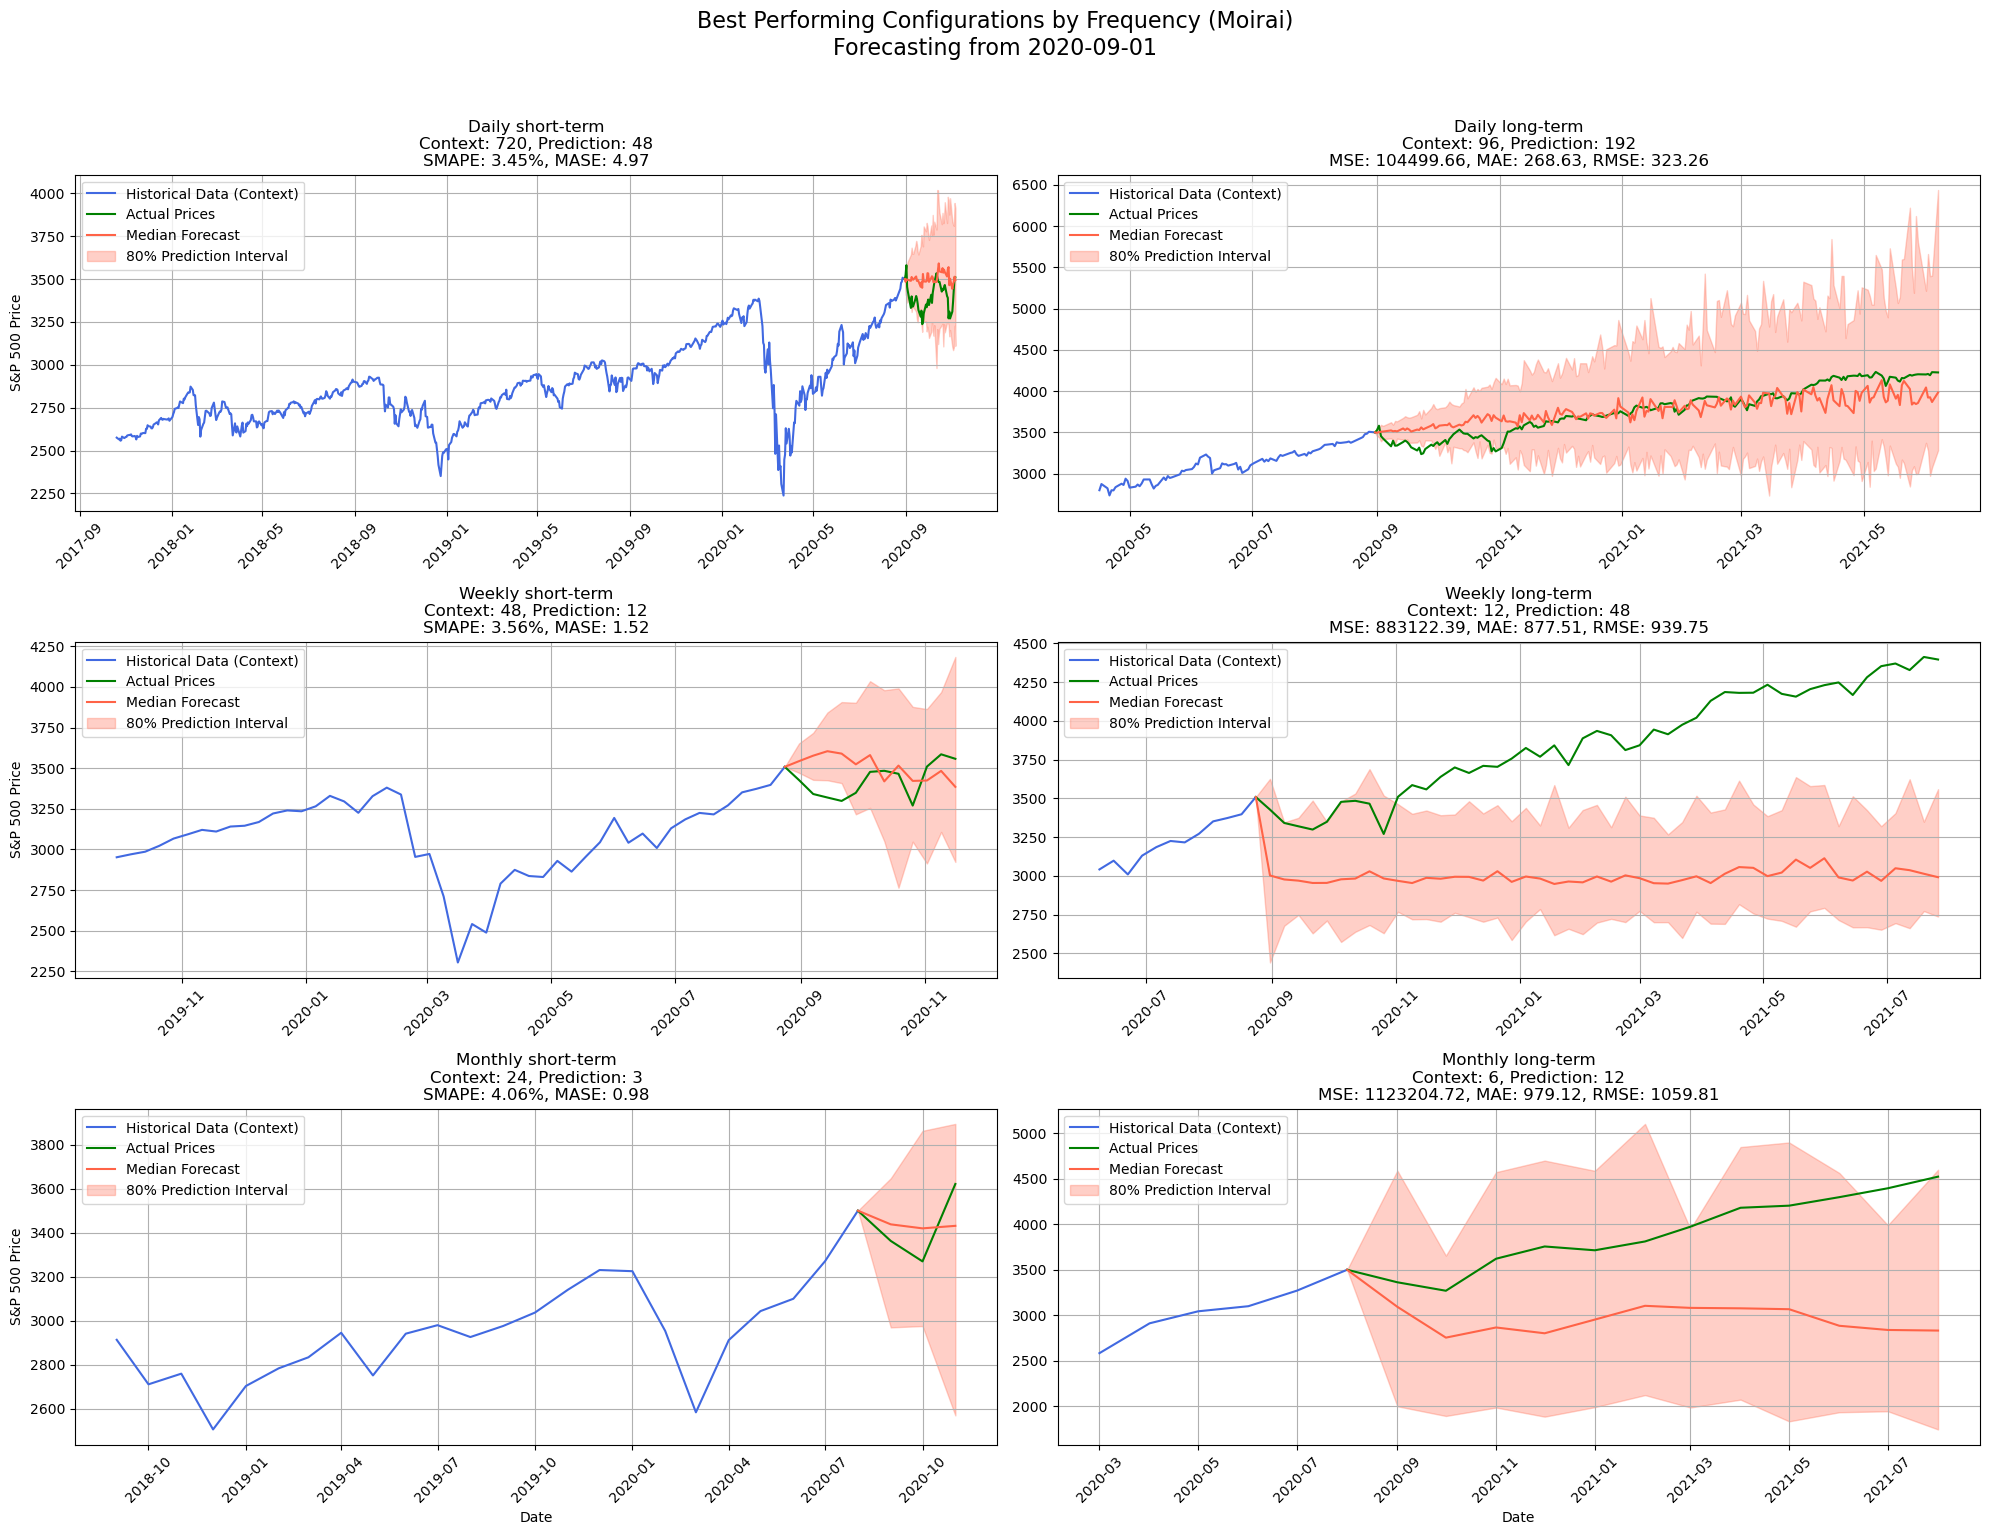


Metrics Comparison - Extended Period vs COVID Period:

Daily Frequency Results:

Short-term metrics:
Extended Period (forecast from 2024-01-01):
context: 720.0000
prediction: 48.0000
MSE: 19808.8094
MAE: 118.4765
RMSE: 140.7438
SMAPE: 3.4522
MASE: 4.9741

COVID Period (forecast from 2021-03-01):
context: 720.0000
prediction: 48.0000
MSE: 19808.8094
MAE: 118.4765
RMSE: 140.7438
SMAPE: 3.4522
MASE: 4.9741

Long-term metrics:
Extended Period (forecast from 2024-01-01):
context: 96.0000
prediction: 192.0000
MSE: 104499.6643
MAE: 268.6332
RMSE: 323.2641
SMAPE: 7.1325
MASE: 8.6604

COVID Period (forecast from 2021-03-01):
context: 96.0000
prediction: 192.0000
MSE: 104499.6643
MAE: 268.6332
RMSE: 323.2641
SMAPE: 7.1325
MASE: 8.6604

Weekly Frequency Results:

Short-term metrics:
Extended Period (forecast from 2024-01-01):
context: 48.0000
prediction: 12.0000
MSE: 22358.6383
MAE: 122.9671
RMSE: 149.5281
SMAPE: 3.5642
MASE: 1.5177

COVID Period (forecast from 2021-03-01):
context: 48.0000
pred

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

from data.snp500 import snp500_daily, snp500_monthly, snp500_weekly
from utils.metrics import metric


def calculate_metrics(actual, predicted, insample=None):
    """Calculate metrics dynamically"""
    mae, mse, rmse, mape, mspe = metric(predicted, actual)

    # Calculate SMAPE
    smape = 200 * np.mean(
        np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual))
    )

    # Calculate MASE if insample data is provided
    if insample is not None:
        naive_forecast = insample[:-1]
        naive_target = insample[1:]
        naive_mae = np.mean(np.abs(naive_target - naive_forecast))
        mase = mae / naive_mae if naive_mae != 0 else np.nan
    else:
        mase = np.nan

    return {"MSE": mse, "MAE": mae, "RMSE": rmse, "SMAPE": smape, "MASE": mase}


def generate_moirai_forecast(context, prediction_window):
    """Generate forecast using Moirai model"""
    context = np.asarray(context).flatten()

    dates = pd.date_range(end=pd.Timestamp.now(), periods=len(context), freq="D")
    context_series = pd.Series(context, index=dates)

    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained("Salesforce/moirai-1.0-R-small"),
        prediction_length=prediction_window,
        context_length=len(context),
        patch_size="auto",
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )
    predictor = model.create_predictor(batch_size=32)

    dataset = PandasDataset({"target": context_series})
    forecasts = list(predictor.predict(dataset))[0]
    forecast_samples = forecasts.samples

    low, median, high = np.quantile(forecast_samples, [0.1, 0.5, 0.9], axis=0)
    return low, median, high


def plot_best_configs(data_dict, configs_dict, forecast_point, time_period):
    """
    Plot best performing configurations for each frequency

    Args:
        data_dict: Dictionary with frequency as key and DataFrame as value
        configs_dict: Dictionary with configurations
        forecast_point: The date from which to start forecasting
        time_period: Tuple of (start_date, end_date) for data selection
    """
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle(
        f"Best Performing Configurations by Frequency (Moirai)\nForecasting from {forecast_point}",
        fontsize=16,
        y=1.02,
    )

    plot_idx = 1

    for freq in ["daily", "weekly", "monthly"]:
        data = data_dict[freq].copy()

        if isinstance(data.index, pd.DatetimeIndex):
            data = data.reset_index()

        if not pd.api.types.is_datetime64_any_dtype(data["Date"]):
            data["Date"] = pd.to_datetime(data["Date"])

        # Filter data for the specified period
        period_data = data[
            (data["Date"] >= time_period[0]) & (data["Date"] <= time_period[1])
        ].reset_index(drop=True)

        # Find the forecast start point
        forecast_start_idx = period_data[period_data["Date"] <= forecast_point].index[
            -1
        ]

        for term in ["short", "long"]:
            ax = plt.subplot(3, 2, plot_idx)

            context_window = configs_dict[freq][term]["context"]
            prediction_window = configs_dict[freq][term]["prediction"]

            # Check if we have enough data before forecast point
            if forecast_start_idx < context_window:
                ax.text(
                    0.5,
                    0.5,
                    f"Insufficient historical data for {freq} {term}-term\n"
                    f"Need {context_window} points before {forecast_point}",
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=ax.transAxes,
                )
                plot_idx += 1
                continue

            # Get data windows relative to forecast point
            window_start = forecast_start_idx - context_window
            window_end = min(
                forecast_start_idx + prediction_window + 1, len(period_data)
            )
            window_data = period_data.iloc[window_start:window_end].copy()

            # Verify we have enough data
            if len(window_data) < context_window + prediction_window:
                ax.text(
                    0.5,
                    0.5,
                    f"Insufficient data for full prediction window\n"
                    f"Need {context_window + prediction_window} points, have {len(window_data)}",
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=ax.transAxes,
                )
                plot_idx += 1
                continue

            # Generate forecast
            context = window_data["Close"].values[:context_window]
            low, median, high = generate_moirai_forecast(context, prediction_window)

            # Calculate metrics
            actual_values = window_data["Close"].values[
                context_window : context_window + prediction_window
            ]
            insample_data = window_data["Close"].values[:context_window]
            metrics = calculate_metrics(actual_values, median, insample=insample_data)

            configs_dict[freq][term].update(metrics)

            # Prepare plotting data
            last_context_point = window_data["Close"].iloc[context_window - 1]

            # Ensure all arrays have the same length (prediction_window + 1 for the last context point)
            plot_actual = np.insert(
                actual_values[:prediction_window], 0, last_context_point
            )
            plot_median = np.insert(median[:prediction_window], 0, last_context_point)
            plot_low = np.insert(low[:prediction_window], 0, last_context_point)
            plot_high = np.insert(high[:prediction_window], 0, last_context_point)

            # Get corresponding dates
            historical_dates = window_data["Date"].iloc[:context_window]
            forecast_dates = window_data["Date"].iloc[
                context_window - 1 : context_window + prediction_window
            ]

            # Ensure all arrays have matching lengths
            assert len(forecast_dates) == len(
                plot_median
            ), f"Length mismatch: dates={len(forecast_dates)}, forecast={len(plot_median)}"

            # Plot
            ax.plot(
                historical_dates,
                window_data["Close"].iloc[:context_window],
                color="royalblue",
                label="Historical Data (Context)",
            )
            ax.plot(forecast_dates, plot_actual, color="green", label="Actual Prices")
            ax.plot(
                forecast_dates, plot_median, color="tomato", label="Median Forecast"
            )
            ax.fill_between(
                forecast_dates,
                plot_low,
                plot_high,
                color="tomato",
                alpha=0.3,
                label="80% Prediction Interval",
            )

            if term == "short":
                title = (
                    f"{freq.capitalize()} {term}-term\n"
                    f"Context: {context_window}, Prediction: {prediction_window}\n"
                    f'SMAPE: {metrics["SMAPE"]:.2f}%, MASE: {metrics["MASE"]:.2f}'
                )
            else:
                title = (
                    f"{freq.capitalize()} {term}-term\n"
                    f"Context: {context_window}, Prediction: {prediction_window}\n"
                    f'MSE: {metrics["MSE"]:.2f}, MAE: {metrics["MAE"]:.2f}, RMSE: {metrics["RMSE"]:.2f}'
                )

            ax.set_title(title)
            ax.tick_params(axis="x", rotation=45)
            if plot_idx % 2 == 1:
                ax.set_ylabel("S&P 500 Price")
            if plot_idx >= 5:
                ax.set_xlabel("Date")
            ax.grid(True)
            ax.legend(loc="upper left")

            plot_idx += 1

    plt.tight_layout()
    plt.show()

    return configs_dict


# Define configurations
configs_dict = {
    "daily": {
        "short": {"context": 720, "prediction": 48},
        "long": {"context": 96, "prediction": 192},
    },
    "weekly": {
        "short": {"context": 48, "prediction": 12},
        "long": {"context": 12, "prediction": 48},
    },
    "monthly": {
        "short": {"context": 24, "prediction": 3},
        "long": {"context": 6, "prediction": 12},
    },
}

# Create data dictionary
data_dict = {"daily": snp500_daily, "weekly": snp500_weekly, "monthly": snp500_monthly}

# Extended period analysis
print("Generating plots for extended period...")
extended_configs = plot_best_configs(
    data_dict,
    configs_dict.copy(),
    forecast_point="2023-06-01",  # Fixed forecast point for extended period
    time_period=("2018-01-01", "2024-12-31"),
)

# COVID period analysis
print("\nGenerating plots for COVID period...")
covid_configs = plot_best_configs(
    data_dict,
    configs_dict.copy(),
    forecast_point="2020-09-01",  # Fixed forecast point during COVID
    time_period=("2016-03-01", "2021-12-31"),
)

# Print comparison of metrics
print("\nMetrics Comparison - Extended Period vs COVID Period:")
for freq in ["daily", "weekly", "monthly"]:
    print(f"\n{freq.capitalize()} Frequency Results:")
    for term in ["short", "long"]:
        print(f"\n{term.capitalize()}-term metrics:")
        print("Extended Period (forecast from 2024-01-01):")
        metrics = extended_configs[freq][term]
        for metric_name, value in metrics.items():
            if value is not None:
                print(f"{metric_name}: {value:.4f}")

        print("\nCOVID Period (forecast from 2021-03-01):")
        metrics = covid_configs[freq][term]
        for metric_name, value in metrics.items():
            if value is not None:
                print(f"{metric_name}: {value:.4f}")


# Experiment on normalized ('standardization') closing prices


Running daily frequency experiments...


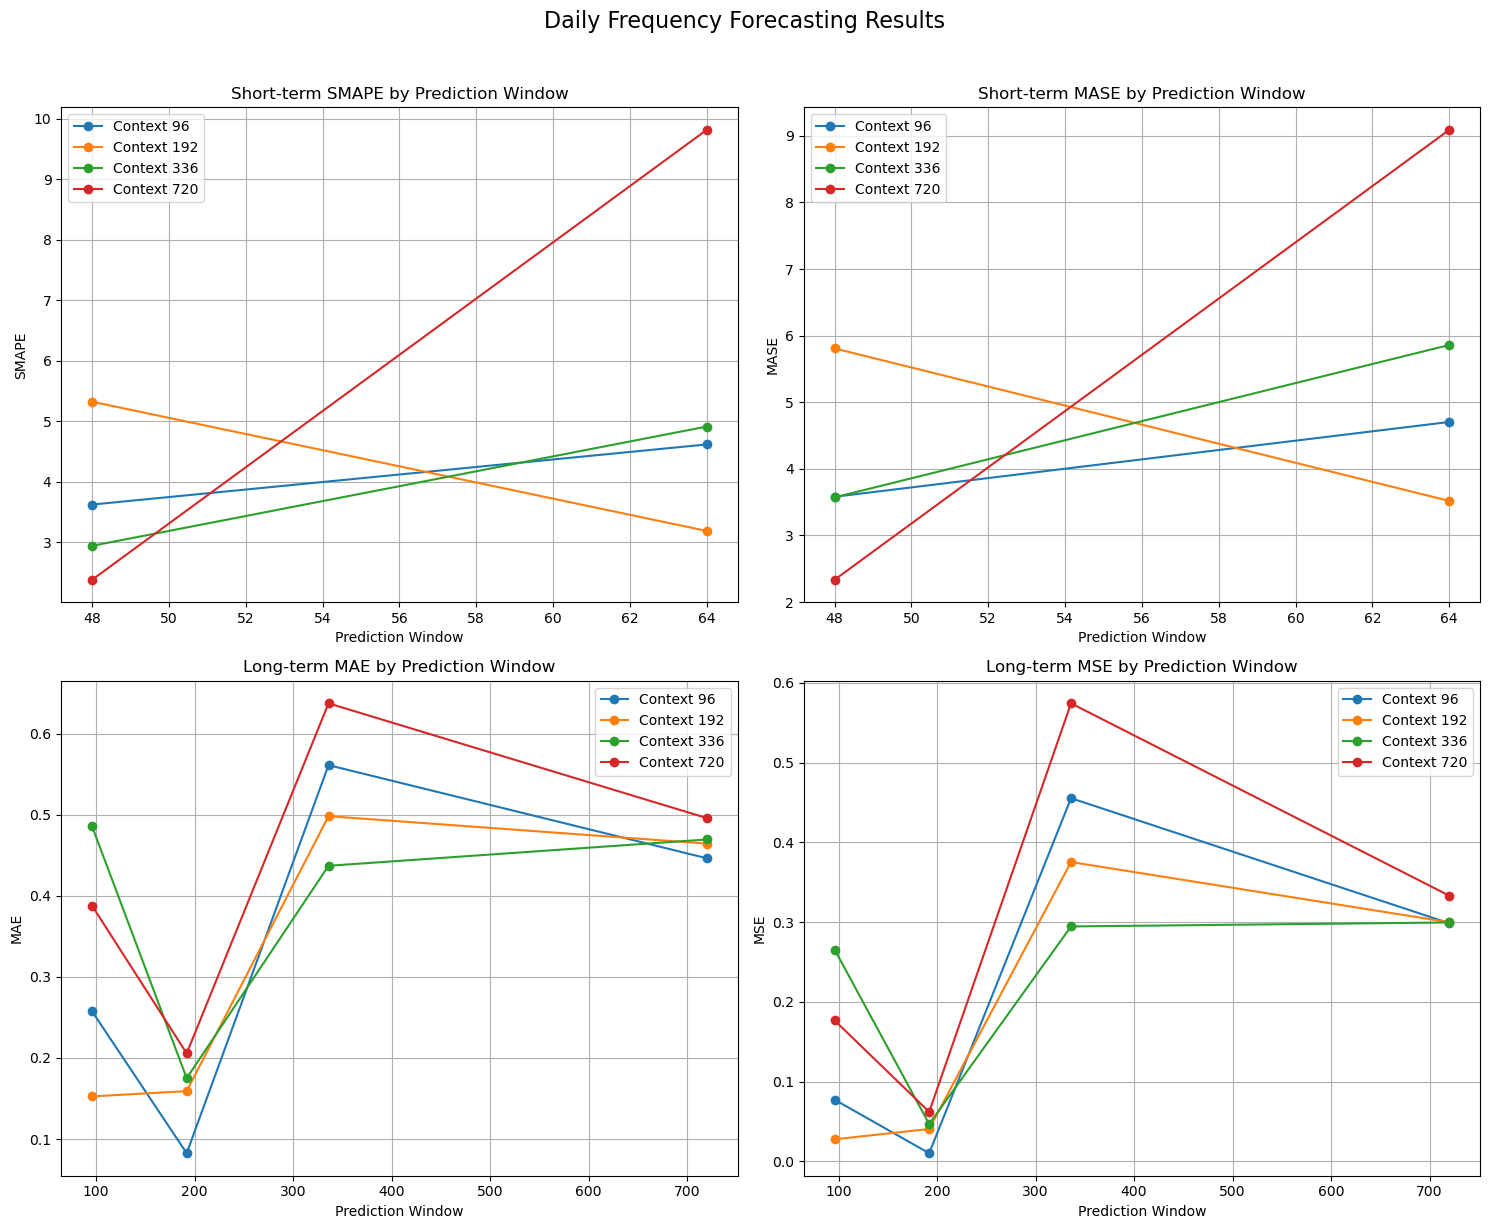


Daily Frequency Results:

Short-term Forecasting Results:
Metric                               MAE    MAPE    MASE     MSE    RMSE  \
Context Window Prediction Window                                           
96             48                 0.1013  3.5480  3.5817  0.0142  0.1192   
               64                 0.1269  4.4660  4.7046  0.0242  0.1556   
192            48                 0.1469  5.1532  5.8088  0.0293  0.1712   
               64                 0.0883  3.1235  3.5191  0.0107  0.1033   
336            48                 0.0824  2.9113  3.5730  0.0093  0.0964   
               64                 0.1349  4.7513  5.8606  0.0258  0.1606   
720            48                 0.0671  2.3739  2.3359  0.0065  0.0809   
               64                 0.2618  9.2812  9.0908  0.0813  0.2851   

Metric                             SMAPE  
Context Window Prediction Window          
96             48                 3.6243  
               64                 4.6176  
192     

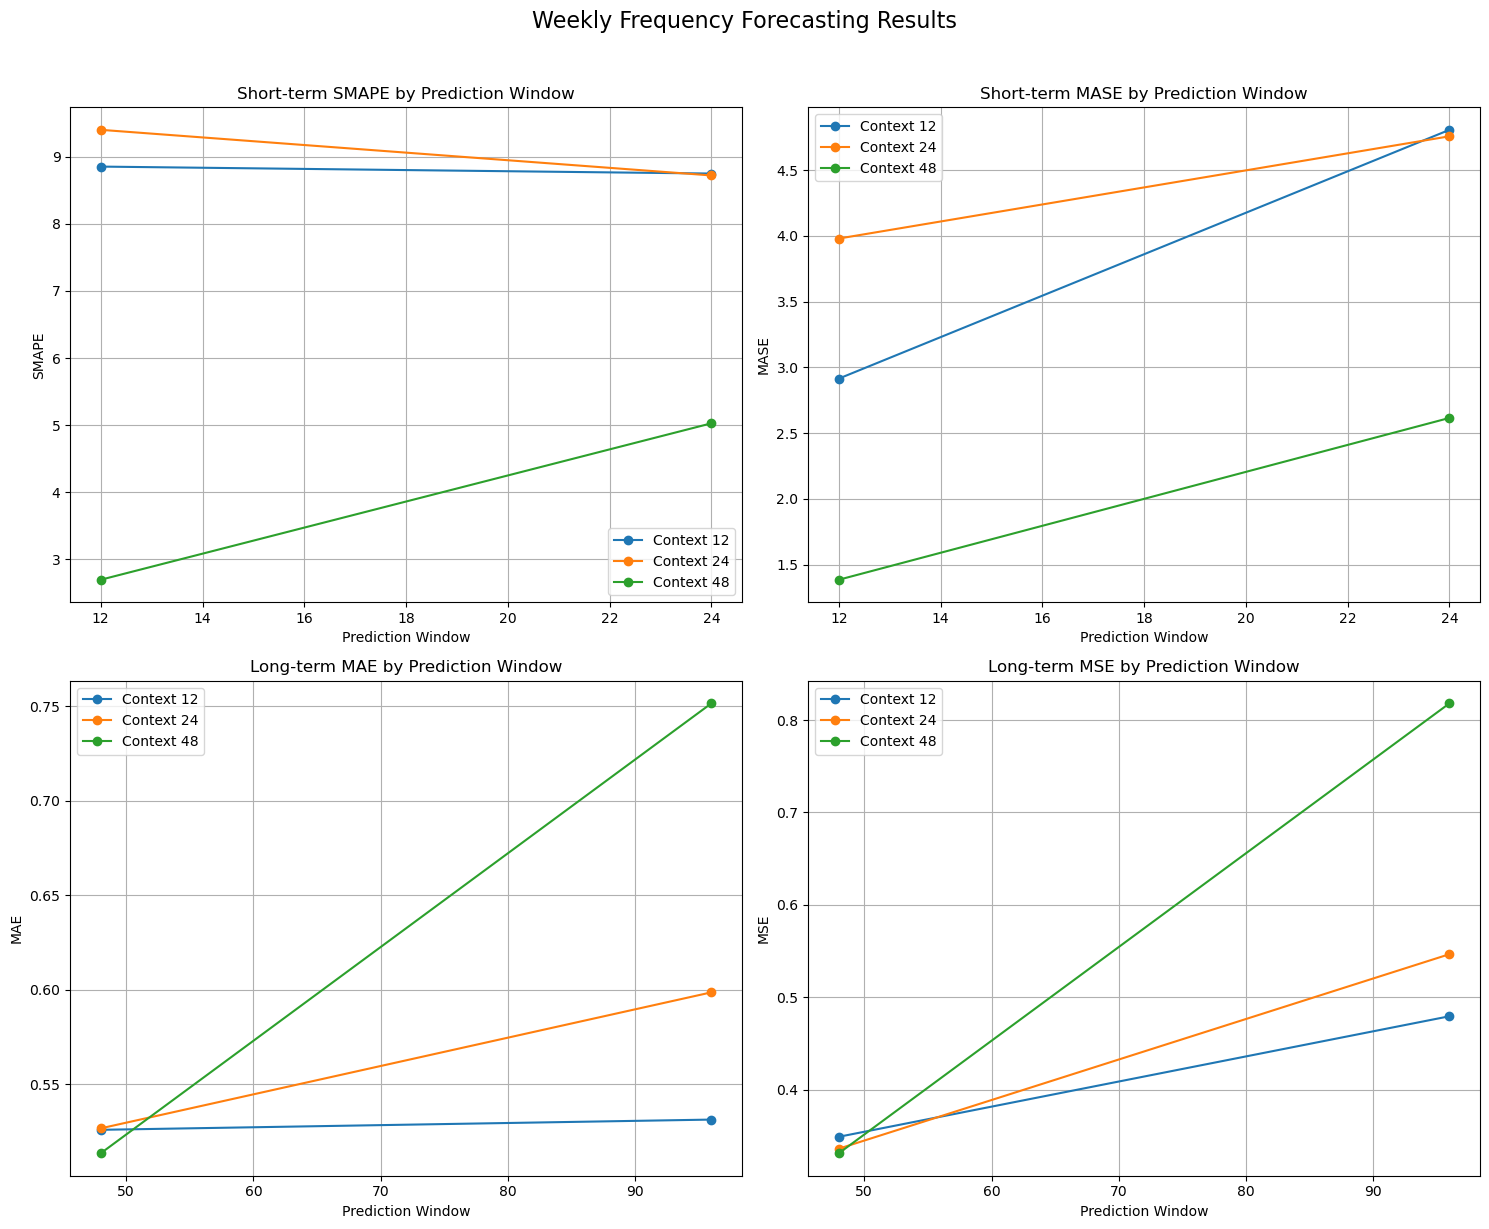


Weekly Frequency Results:

Short-term Forecasting Results:
Metric                               MAE    MAPE    MASE     MSE    RMSE  \
Context Window Prediction Window                                           
12             12                 0.2383  8.4199  2.9149  0.0668  0.2585   
               24                 0.2275  8.2694  4.8074  0.0733  0.2708   
24             12                 0.2523  8.9042  3.9804  0.0765  0.2765   
               24                 0.2267  8.2379  4.7583  0.0736  0.2712   
48             12                 0.0756  2.6693  1.3846  0.0098  0.0990   
               24                 0.1325  4.9636  2.6155  0.0238  0.1543   

Metric                             SMAPE  
Context Window Prediction Window          
12             12                 8.8526  
               24                 8.7490  
24             12                 9.4006  
               24                 8.7207  
48             12                 2.6955  
               24             

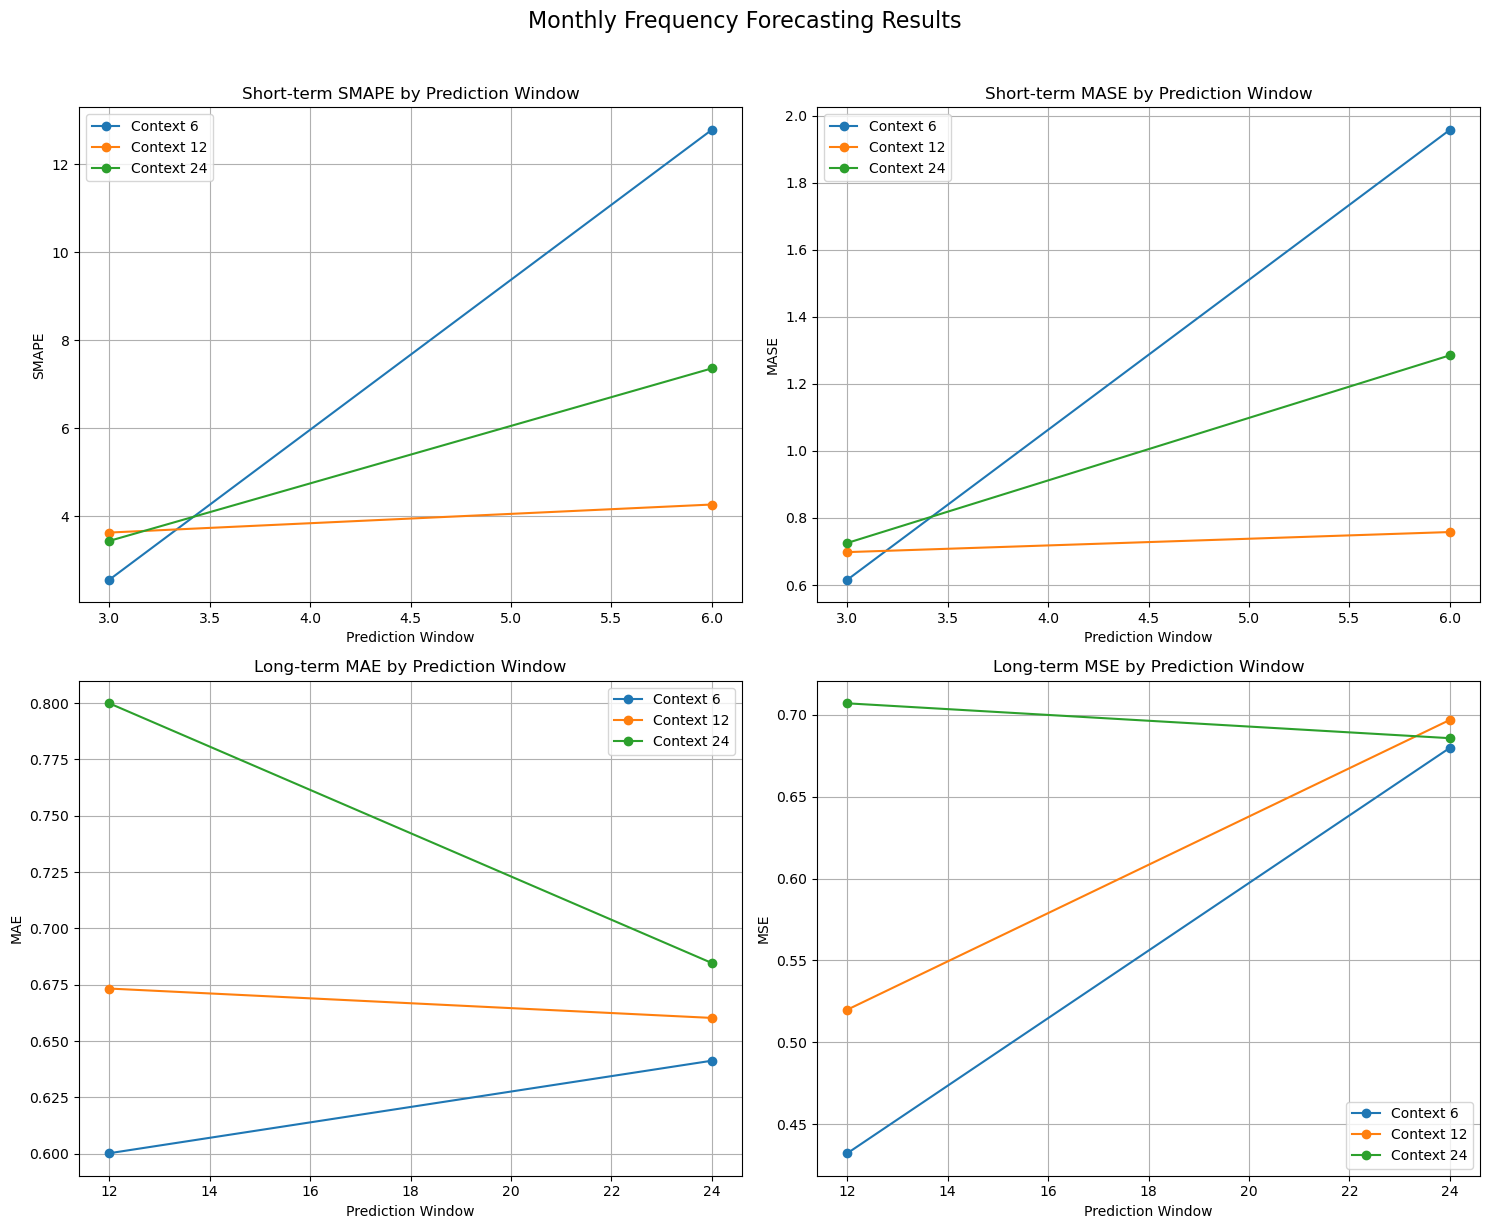


Monthly Frequency Results:

Short-term Forecasting Results:
Metric                               MAE     MAPE    MASE     MSE    RMSE  \
Context Window Prediction Window                                            
6              3                  0.0697   2.5704  0.6158  0.0073  0.0856   
               6                  0.3208  11.9153  1.9577  0.1201  0.3465   
12             3                  0.0991   3.7538  0.6982  0.0179  0.1338   
               6                  0.1126   4.1929  0.7581  0.0168  0.1296   
24             3                  0.0936   3.4399  0.7255  0.0092  0.0958   
               6                  0.1889   7.0542  1.2851  0.0423  0.2056   

Metric                              SMAPE  
Context Window Prediction Window           
6              3                   2.5560  
               6                  12.7841  
12             3                   3.6283  
               6                   4.2656  
24             3                   3.4384  
              

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

from data.snp500 import snp500_daily, snp500_monthly, snp500_weekly
from utils.evaluate import NormalizedReturnExperiments


def moirai_forecast(model, context, prediction_window):
    """Forecast function for Moirai model"""
    # Ensure data is 1D
    context = np.asarray(context).flatten()

    # Create a pandas Series with datetime index
    dates = pd.date_range(end=pd.Timestamp.now(), periods=len(context), freq="D")
    context_series = pd.Series(context, index=dates)

    # Create new model instance with correct prediction length
    model_instance = MoiraiForecast(
        module=MoiraiModule.from_pretrained("Salesforce/moirai-1.0-R-small"),
        prediction_length=prediction_window,
        context_length=len(context),
        patch_size="auto",
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )
    predictor = model_instance.create_predictor(batch_size=32)

    # Prepare data in GluonTS format
    dataset = PandasDataset({"target": context_series})

    # Generate forecast
    forecasts = list(predictor.predict(dataset))[0]
    forecast_samples = forecasts.samples

    # Extract quantiles and ensure correct length
    low, median, high = np.quantile(forecast_samples, [0.1, 0.5, 0.9], axis=0)

    # Verify lengths match expected prediction window
    assert (
        len(median) == prediction_window
    ), f"Prediction length mismatch: got {len(median)}, expected {prediction_window}"

    return low, median, high


def plot_results_by_frequency(results_df, frequency):
    """Create plots for short-term and long-term metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(
        f"{frequency.capitalize()} Frequency Forecasting Results", fontsize=16, y=1.02
    )

    # Short-term metrics (SMAPE and MASE)
    short_term = results_df[results_df["Horizon"] == "short_term"]
    context_windows = sorted(short_term["Context Window"].unique())

    # Plot SMAPE
    ax = axes[0, 0]
    for context in context_windows:
        data = short_term[
            (short_term["Context Window"] == context)
            & (short_term["Metric"] == "SMAPE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("SMAPE")
    ax.set_title("Short-term SMAPE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Plot MASE
    ax = axes[0, 1]
    for context in context_windows:
        data = short_term[
            (short_term["Context Window"] == context) & (short_term["Metric"] == "MASE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MASE")
    ax.set_title("Short-term MASE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Long-term metrics (MAE and MSE)
    long_term = results_df[results_df["Horizon"] == "long_term"]

    # Plot MAE
    ax = axes[1, 0]
    for context in context_windows:
        data = long_term[
            (long_term["Context Window"] == context) & (long_term["Metric"] == "MAE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MAE")
    ax.set_title("Long-term MAE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Plot MSE
    ax = axes[1, 1]
    for context in context_windows:
        data = long_term[
            (long_term["Context Window"] == context) & (long_term["Metric"] == "MSE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MSE")
    ax.set_title("Long-term MSE by Prediction Window")
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()


# Initialize experiment runner with dummy model (will be recreated for each prediction)
dummy_model = None  # Model will be created dynamically in moirai_forecast

experiments = NormalizedReturnExperiments(
    model=dummy_model, forecast_fn=moirai_forecast
)

# Dictionary to store results for each frequency
frequency_results = {}

# Run experiments for each frequency
frequencies = {
    "daily": snp500_daily,
    "weekly": snp500_weekly,
    "monthly": snp500_monthly,
}

for freq, data in frequencies.items():
    print(f"\nRunning {freq} frequency experiments...")

    # Run experiments
    results = experiments.run_frequency_experiments(data, freq)
    frequency_results[freq] = results

    # Format results
    df_results = experiments.format_results(results)

    # Create visualizations
    plot_results_by_frequency(df_results, freq)

    # Create separate DataFrames for short-term and long-term results
    short_term_df = (
        df_results[df_results["Horizon"] == "short_term"]
        .pivot_table(
            index=["Context Window", "Prediction Window"],
            columns="Metric",
            values="Value",
        )
        .round(4)
    )

    long_term_df = (
        df_results[df_results["Horizon"] == "long_term"]
        .pivot_table(
            index=["Context Window", "Prediction Window"],
            columns="Metric",
            values="Value",
        )
        .round(4)
    )

    print(f"\n{freq.capitalize()} Frequency Results:")
    print("\nShort-term Forecasting Results:")
    print(short_term_df)
    print("\nLong-term Forecasting Results:")
    print(long_term_df)
